# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [262]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

In [263]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

# mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
# pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

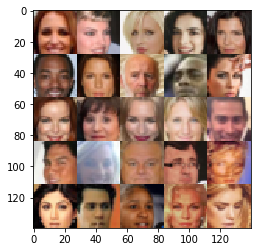

In [264]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [265]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [266]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input_images = tf.placeholder(tf.float32,(None,image_width,image_height,image_channels),name='real_input')
    z_data = tf.placeholder(tf.float32,(None,z_dim),name='z_data')
    learning_rate = tf.placeholder(tf.float32,name='learning_rate')
    return (real_input_images,z_data,learning_rate)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/opt/conda/lib/python3.6/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/opt/conda/lib/python3.6/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/opt/conda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 478, in start\n    self.io_loop.start()', 'File "/opt/conda/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start\n    super(ZMQIOLoop, self).start()', 'File "/opt/co

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [267]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.1
    keep_prob =0.9
    with tf.variable_scope('discriminator',reuse=reuse):
        x1 = tf.layers.conv2d(images,64,5,strides=2,padding="SAME")
        x1 = tf.maximum(alpha*x1,x1)
        
        x2 = tf.layers.conv2d(x1,128,5,strides=2,padding="SAME")
        x2 = tf.layers.batch_normalization(x2)
        x2 = tf.maximum(alpha*x2,x2)
        x2 = tf.nn.dropout(x2, keep_prob=keep_prob )
        
        x3 = tf.layers.conv2d(x2,256,5,strides=2,padding="SAME")
        x3 = tf.layers.batch_normalization(x3)
        x3 = tf.maximum(alpha*x3,x3)
        x3 = tf.nn.dropout(x3, keep_prob=keep_prob )
        
        flat = tf.reshape(x3,(-1,4*4*256))
        logits = tf.layers.dense(flat,1)   
        out = tf.sigmoid(logits)
        
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [268]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.1
    keep_prob =0.9
    with tf.variable_scope("generator",reuse=not is_train):
        x1 = tf.layers.dense(z,7*7*512)
        x1 = tf.reshape(x1,(-1,7,7,512))
        x1 = tf.layers.batch_normalization(x1,training=is_train)
        x1 = tf.maximum(alpha*x1,x1)
        
        
        x2 = tf.layers.conv2d_transpose(x1,256,5,strides=2,padding="same")
        x2 = tf.layers.batch_normalization(x2,training=is_train)
        x2 = tf.maximum(alpha*x2,x2)
        x2 = tf.nn.dropout(x2,keep_prob=keep_prob)
        
        x3 = tf.layers.conv2d_transpose(x2,128,5,strides=2,padding="same")
        x3 = tf.layers.batch_normalization(x3,training=is_train)
       
        x3 = tf.maximum(alpha*x3,x3)
        x3 = tf.nn.dropout(x3,keep_prob=keep_prob)
        
        
        logits  = tf.layers.conv2d_transpose(x3,out_channel_dim,3,strides=1,padding="same")
        
        out = tf.tanh(logits)
    
    return out
   
   


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [269]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    smooth = 0.1
    g_model = generator(input_z,out_channel_dim)
    
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake , d_logits_fake = discriminator(g_model,reuse=True)
    
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,labels=tf.ones_like(d_model_real)* (1 - smooth)))
    
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,labels=tf.zeros_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,labels=tf.ones_like(d_model_fake)))
    
    return d_loss, g_loss



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [270]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    train_vars = tf.trainable_variables()
    disc_vars = [var for var in train_vars if var.name.startswith('discriminator')]
    gen_vars = [var for var in train_vars if var.name.startswith('generator')]
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

    with tf.control_dependencies(update_ops):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=disc_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss,var_list=gen_vars)  
        return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [271]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [272]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    _,image_width, image_height, image_channels = data_shape
    real_input_images , z_data, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss,g_loss = model_loss(real_input_images,z_data,image_channels)
    d_train_opt,g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)   
    
    saver = tf.train.Saver()
    losses = []
    steps = 0
    total_steps = epoch_count * batch_size
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                batch_images *= 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                _ = sess.run(d_train_opt,feed_dict={real_input_images:batch_images,z_data:batch_z,lr:learning_rate})
                _ = sess.run(g_train_opt,feed_dict={real_input_images:batch_images,z_data:batch_z,lr:learning_rate})
                
                if steps==1:
                    print ("Initial output")
                    show_generator_output(sess,16,z_data,image_channels,data_image_mode)
                    
                if steps%25 == 0:
                    train_loss_d= d_loss.eval({real_input_images:batch_images,z_data:batch_z})
                    train_loss_g = g_loss.eval({z_data:batch_z})
                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                            "Generator Loss: {:.4f}".format(train_loss_g),
                            "Discriminator Loss: {:.4f}...".format(train_loss_d))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))
                if steps%100 == 0:
                    print ("Final output")
                    show_generator_output(sess,16,z_data,image_channels,data_image_mode)
        saver.save(sess, './generator.ckpt')
                
    return losses

                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

In [273]:
# batch_size = 120
# z_dim = 100
# learning_rate = 0.0002
# beta1 = 0.5


# """
# DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
# """
# epochs = 2

# mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
# with tf.Graph().as_default():
#     train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
#           mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Initial output


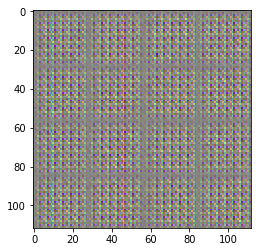

Epoch 1/1... Generator Loss: 0.1392 Discriminator Loss: 2.3947...
Epoch 1/1... Generator Loss: 5.5069 Discriminator Loss: 0.4201...
Epoch 1/1... Generator Loss: 3.5273 Discriminator Loss: 0.4387...
Epoch 1/1... Generator Loss: 2.8496 Discriminator Loss: 0.5877...
Final output


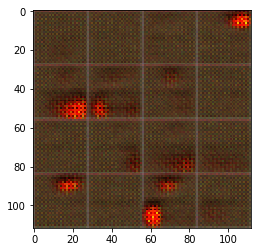

Epoch 1/1... Generator Loss: 1.7231 Discriminator Loss: 1.1478...
Epoch 1/1... Generator Loss: 1.3609 Discriminator Loss: 1.1252...
Epoch 1/1... Generator Loss: 1.1103 Discriminator Loss: 1.2869...
Epoch 1/1... Generator Loss: 1.4199 Discriminator Loss: 1.1254...
Final output


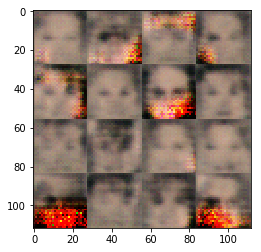

Epoch 1/1... Generator Loss: 0.9774 Discriminator Loss: 1.3392...
Epoch 1/1... Generator Loss: 1.2693 Discriminator Loss: 1.2934...
Epoch 1/1... Generator Loss: 0.9943 Discriminator Loss: 1.1947...
Epoch 1/1... Generator Loss: 0.9556 Discriminator Loss: 1.1747...
Final output


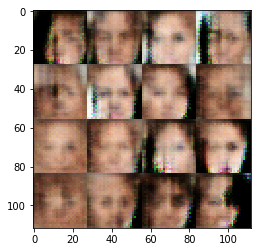

Epoch 1/1... Generator Loss: 1.1901 Discriminator Loss: 1.2573...
Epoch 1/1... Generator Loss: 1.4444 Discriminator Loss: 1.3130...
Epoch 1/1... Generator Loss: 0.9395 Discriminator Loss: 1.2412...
Epoch 1/1... Generator Loss: 0.8740 Discriminator Loss: 1.2764...
Final output


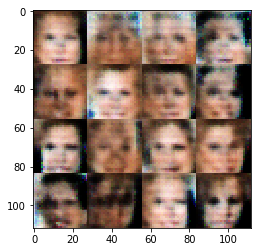

Epoch 1/1... Generator Loss: 0.7029 Discriminator Loss: 1.4431...
Epoch 1/1... Generator Loss: 0.8854 Discriminator Loss: 1.1920...
Epoch 1/1... Generator Loss: 1.1960 Discriminator Loss: 1.1890...
Epoch 1/1... Generator Loss: 1.2759 Discriminator Loss: 1.1803...
Final output


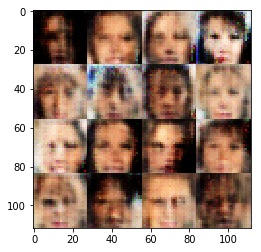

Epoch 1/1... Generator Loss: 1.0827 Discriminator Loss: 1.2652...
Epoch 1/1... Generator Loss: 0.7050 Discriminator Loss: 1.3503...
Epoch 1/1... Generator Loss: 1.1584 Discriminator Loss: 1.2187...
Epoch 1/1... Generator Loss: 0.7924 Discriminator Loss: 1.2509...
Final output


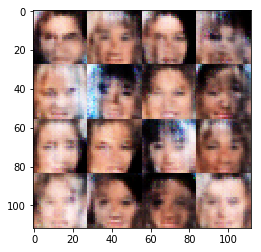

Epoch 1/1... Generator Loss: 0.9596 Discriminator Loss: 1.1829...
Epoch 1/1... Generator Loss: 1.1720 Discriminator Loss: 1.3016...
Epoch 1/1... Generator Loss: 1.0004 Discriminator Loss: 1.2348...
Epoch 1/1... Generator Loss: 1.1061 Discriminator Loss: 1.2648...
Final output


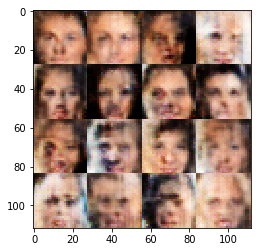

Epoch 1/1... Generator Loss: 1.1183 Discriminator Loss: 1.2711...
Epoch 1/1... Generator Loss: 0.5407 Discriminator Loss: 1.5076...
Epoch 1/1... Generator Loss: 0.8586 Discriminator Loss: 1.3389...
Epoch 1/1... Generator Loss: 0.6376 Discriminator Loss: 1.3669...
Final output


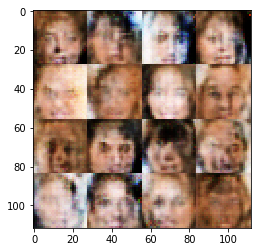

Epoch 1/1... Generator Loss: 1.0058 Discriminator Loss: 1.3256...
Epoch 1/1... Generator Loss: 0.7786 Discriminator Loss: 1.3275...
Epoch 1/1... Generator Loss: 0.9441 Discriminator Loss: 1.2804...
Epoch 1/1... Generator Loss: 0.7051 Discriminator Loss: 1.3119...
Final output


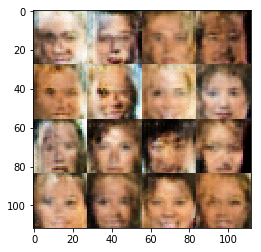

Epoch 1/1... Generator Loss: 1.2442 Discriminator Loss: 1.3187...
Epoch 1/1... Generator Loss: 0.5544 Discriminator Loss: 1.5155...
Epoch 1/1... Generator Loss: 1.0275 Discriminator Loss: 1.2522...
Epoch 1/1... Generator Loss: 1.1715 Discriminator Loss: 1.2880...
Final output


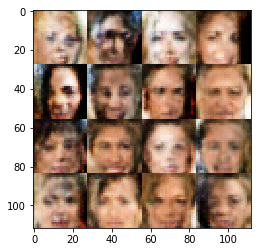

Epoch 1/1... Generator Loss: 0.8975 Discriminator Loss: 1.3319...
Epoch 1/1... Generator Loss: 1.0775 Discriminator Loss: 1.3888...
Epoch 1/1... Generator Loss: 0.8265 Discriminator Loss: 1.4100...
Epoch 1/1... Generator Loss: 0.9919 Discriminator Loss: 1.3044...
Final output


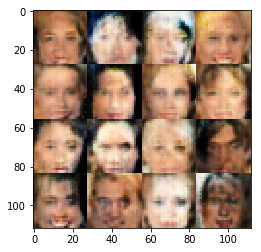

Epoch 1/1... Generator Loss: 0.8382 Discriminator Loss: 1.3935...
Epoch 1/1... Generator Loss: 0.9295 Discriminator Loss: 1.2862...
Epoch 1/1... Generator Loss: 0.7145 Discriminator Loss: 1.4091...
Epoch 1/1... Generator Loss: 0.8776 Discriminator Loss: 1.3973...
Final output


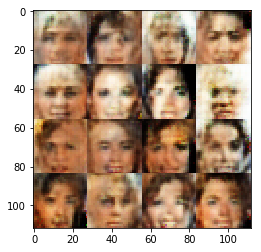

Epoch 1/1... Generator Loss: 1.0194 Discriminator Loss: 1.3136...
Epoch 1/1... Generator Loss: 0.7517 Discriminator Loss: 1.3990...
Epoch 1/1... Generator Loss: 0.8218 Discriminator Loss: 1.3061...
Epoch 1/1... Generator Loss: 1.0528 Discriminator Loss: 1.3194...
Final output


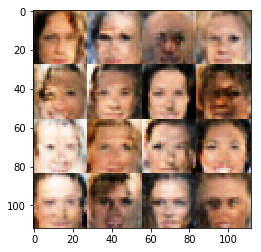

Epoch 1/1... Generator Loss: 0.9769 Discriminator Loss: 1.3335...
Epoch 1/1... Generator Loss: 0.8140 Discriminator Loss: 1.4101...
Epoch 1/1... Generator Loss: 0.8798 Discriminator Loss: 1.3196...
Epoch 1/1... Generator Loss: 0.8186 Discriminator Loss: 1.3774...
Final output


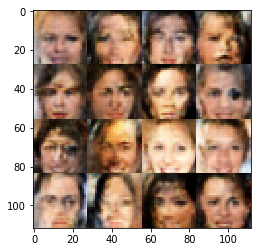

Epoch 1/1... Generator Loss: 1.0257 Discriminator Loss: 1.3143...
Epoch 1/1... Generator Loss: 0.8344 Discriminator Loss: 1.3250...
Epoch 1/1... Generator Loss: 0.7522 Discriminator Loss: 1.3994...
Epoch 1/1... Generator Loss: 1.1363 Discriminator Loss: 1.2602...
Final output


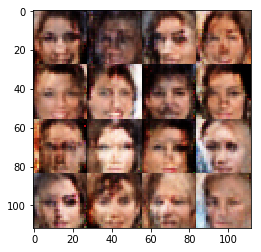

Epoch 1/1... Generator Loss: 0.7210 Discriminator Loss: 1.3436...
Epoch 1/1... Generator Loss: 0.8441 Discriminator Loss: 1.3310...
Epoch 1/1... Generator Loss: 0.8535 Discriminator Loss: 1.3248...
Epoch 1/1... Generator Loss: 0.9052 Discriminator Loss: 1.3440...
Final output


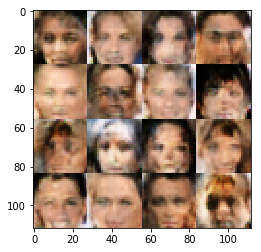

Epoch 1/1... Generator Loss: 0.8012 Discriminator Loss: 1.3226...
Epoch 1/1... Generator Loss: 0.7625 Discriminator Loss: 1.3678...
Epoch 1/1... Generator Loss: 0.8282 Discriminator Loss: 1.3276...
Epoch 1/1... Generator Loss: 1.0080 Discriminator Loss: 1.2763...
Final output


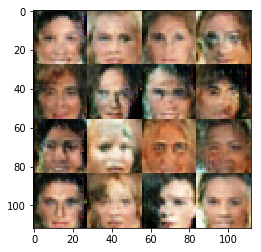

Epoch 1/1... Generator Loss: 0.7714 Discriminator Loss: 1.3387...
Epoch 1/1... Generator Loss: 0.8074 Discriminator Loss: 1.3314...
Epoch 1/1... Generator Loss: 0.9836 Discriminator Loss: 1.2960...
Epoch 1/1... Generator Loss: 0.8494 Discriminator Loss: 1.3513...
Final output


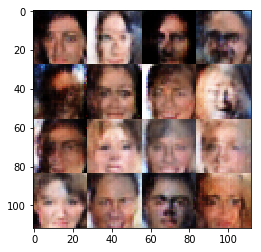

Epoch 1/1... Generator Loss: 0.8396 Discriminator Loss: 1.3652...
Epoch 1/1... Generator Loss: 0.7645 Discriminator Loss: 1.3530...
Epoch 1/1... Generator Loss: 0.7491 Discriminator Loss: 1.4014...
Epoch 1/1... Generator Loss: 0.8115 Discriminator Loss: 1.3548...
Final output


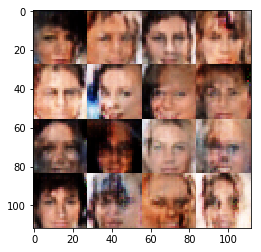

Epoch 1/1... Generator Loss: 0.9284 Discriminator Loss: 1.3206...
Epoch 1/1... Generator Loss: 0.8460 Discriminator Loss: 1.3273...
Epoch 1/1... Generator Loss: 0.8272 Discriminator Loss: 1.3518...
Epoch 1/1... Generator Loss: 0.7790 Discriminator Loss: 1.3769...
Final output


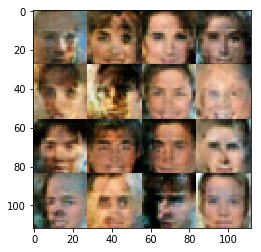

Epoch 1/1... Generator Loss: 0.7860 Discriminator Loss: 1.3902...
Epoch 1/1... Generator Loss: 0.9466 Discriminator Loss: 1.4082...
Epoch 1/1... Generator Loss: 0.7896 Discriminator Loss: 1.3261...
Epoch 1/1... Generator Loss: 0.8614 Discriminator Loss: 1.3337...
Final output


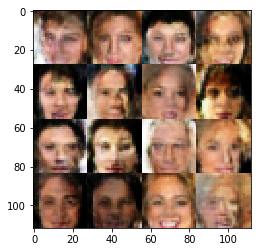

Epoch 1/1... Generator Loss: 0.8062 Discriminator Loss: 1.3310...
Epoch 1/1... Generator Loss: 0.7927 Discriminator Loss: 1.4000...
Epoch 1/1... Generator Loss: 0.7278 Discriminator Loss: 1.3565...
Epoch 1/1... Generator Loss: 0.8405 Discriminator Loss: 1.4282...
Final output


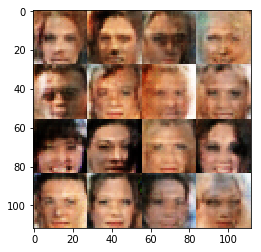

Epoch 1/1... Generator Loss: 0.9703 Discriminator Loss: 1.3570...
Epoch 1/1... Generator Loss: 0.7986 Discriminator Loss: 1.3942...
Epoch 1/1... Generator Loss: 0.8844 Discriminator Loss: 1.3880...
Epoch 1/1... Generator Loss: 0.8830 Discriminator Loss: 1.3629...
Final output


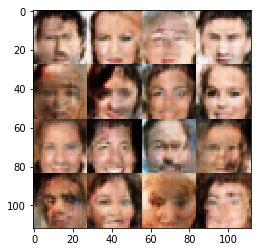

Epoch 1/1... Generator Loss: 0.7937 Discriminator Loss: 1.3909...
Epoch 1/1... Generator Loss: 0.7783 Discriminator Loss: 1.3726...
Epoch 1/1... Generator Loss: 0.7974 Discriminator Loss: 1.3784...
Epoch 1/1... Generator Loss: 0.7994 Discriminator Loss: 1.3691...
Final output


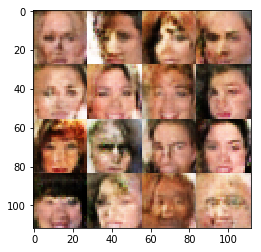

Epoch 1/1... Generator Loss: 0.8981 Discriminator Loss: 1.3780...
Epoch 1/1... Generator Loss: 0.8736 Discriminator Loss: 1.4297...
Epoch 1/1... Generator Loss: 0.7810 Discriminator Loss: 1.3798...
Epoch 1/1... Generator Loss: 0.7716 Discriminator Loss: 1.3216...
Final output


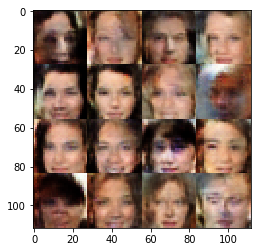

Epoch 1/1... Generator Loss: 0.7825 Discriminator Loss: 1.3967...
Epoch 1/1... Generator Loss: 0.7881 Discriminator Loss: 1.3229...
Epoch 1/1... Generator Loss: 0.7889 Discriminator Loss: 1.3429...
Epoch 1/1... Generator Loss: 0.7240 Discriminator Loss: 1.3605...
Final output


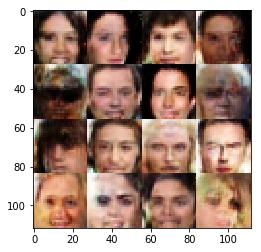

Epoch 1/1... Generator Loss: 1.0096 Discriminator Loss: 1.3530...
Epoch 1/1... Generator Loss: 0.8310 Discriminator Loss: 1.3721...
Epoch 1/1... Generator Loss: 0.7971 Discriminator Loss: 1.3537...
Epoch 1/1... Generator Loss: 0.8254 Discriminator Loss: 1.3221...
Final output


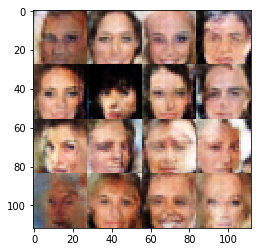

Epoch 1/1... Generator Loss: 0.7814 Discriminator Loss: 1.3505...
Epoch 1/1... Generator Loss: 0.7683 Discriminator Loss: 1.3783...
Epoch 1/1... Generator Loss: 0.7980 Discriminator Loss: 1.3252...
Epoch 1/1... Generator Loss: 0.7923 Discriminator Loss: 1.3506...
Final output


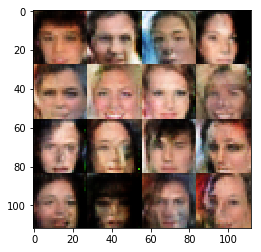

Epoch 1/1... Generator Loss: 0.7503 Discriminator Loss: 1.3364...
Epoch 1/1... Generator Loss: 0.7649 Discriminator Loss: 1.4013...
Epoch 1/1... Generator Loss: 0.8708 Discriminator Loss: 1.3465...
Epoch 1/1... Generator Loss: 0.7863 Discriminator Loss: 1.3224...
Final output


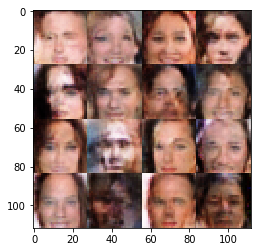

Epoch 1/1... Generator Loss: 0.8162 Discriminator Loss: 1.3080...
Epoch 1/1... Generator Loss: 0.8047 Discriminator Loss: 1.3372...
Epoch 1/1... Generator Loss: 0.7644 Discriminator Loss: 1.3413...
Epoch 1/1... Generator Loss: 0.7902 Discriminator Loss: 1.3690...
Final output


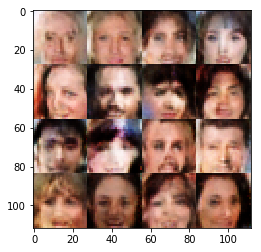

Epoch 1/1... Generator Loss: 0.7728 Discriminator Loss: 1.3341...
Epoch 1/1... Generator Loss: 0.7211 Discriminator Loss: 1.3110...
Epoch 1/1... Generator Loss: 0.7343 Discriminator Loss: 1.3671...
Epoch 1/1... Generator Loss: 0.7847 Discriminator Loss: 1.3704...
Final output


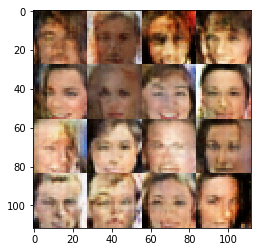

Epoch 1/1... Generator Loss: 0.8518 Discriminator Loss: 1.2843...
Epoch 1/1... Generator Loss: 0.8221 Discriminator Loss: 1.3297...


In [274]:
# batch_size = 64
# z_dim = 200
# learning_rate = 0.0004
# beta1 = 0.5
batch_size = 64
z_dim = 200
learning_rate = 0.0004
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.